# Movement Quality Classification with Interpretability

Binary classifier for assessing athlete movement quality with comprehensive interpretability via **Grad-CAM** and **Integrated Gradients**.

**Features:**
- TCN-based encoder with dilated convolutions for large receptive field
- Classification head for optimal vs suboptimal movement
- Grad-CAM attention visualization (temporal importance)
- Integrated Gradients attribution (per-channel, per-timestep)
- Per-channel sensitivity analysis via occlusion
- Comprehensive evaluation metrics (ROC-AUC, PR-AUC, confusion matrix)
- Model saving/loading and inference pipeline

## 1. Setup & Configuration

In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torch.optim import Adam
from torch.optim.lr_scheduler import CosineAnnealingWarmRestarts
from dataclasses import dataclass, field
from typing import Tuple, Optional, List, Dict
from collections import defaultdict
import matplotlib.pyplot as plt
from sklearn.metrics import (
    confusion_matrix, classification_report, roc_curve, auc,
    precision_recall_curve, average_precision_score
)
import json
import os
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

# Import existing utilities
from pitch_models import DilatedResidualBlock
from pitch_dataset import WindowedTimeSeriesDataset, window_collate
from pitch_utils import load_processed_trials, normalize_batch, fit_channel_stats_windows

# Device setup
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


In [2]:
# ============================================================================
# CONFIGURATION DATACLASSES
# ============================================================================

@dataclass
class DataConfig:
    """Data pipeline configuration."""
    window_size: int = 128
    window_stride: int = 32
    batch_size: int = 64
    val_fraction: float = 0.2
    test_fraction: float = 0.1
    num_workers: int = 0
    pin_memory: bool = True
    sampling_rate: int = 240
    num_channels: int = 8


@dataclass
class TrainingConfig:
    """Training hyperparameters."""
    epochs: int = 500
    lr: float = 1e-3
    weight_decay: float = 1e-3
    patience: int = 100
    scheduler_T0: int = 50
    scheduler_T_mult: int = 2
    gradient_clip: float = 1.0
    seed: int = 42


@dataclass
class ModelConfig:
    """Shared model configuration."""
    in_channels: int = 8
    latent_dim: int = 64
    dropout: float = 0.2


@dataclass
class ClassifierConfig:
    """Classifier configuration."""
    num_classes: int = 1
    hidden_dim: int = 128
    label_smoothing: float = 0.1
    classifier_dropout: float = 0.3


@dataclass
class AugmentationConfig:
    """Data augmentation configuration."""
    time_warp_prob: float = 0.3
    time_warp_sigma: float = 0.2
    scale_prob: float = 0.3
    scale_range: Tuple[float, float] = (0.8, 1.2)
    channel_dropout_prob: float = 0.2
    noise_prob: float = 0.3
    noise_std: float = 0.05


@dataclass
class Config:
    """Master configuration combining all sub-configs."""
    data: DataConfig = field(default_factory=DataConfig)
    training: TrainingConfig = field(default_factory=TrainingConfig)
    model: ModelConfig = field(default_factory=ModelConfig)
    classifier: ClassifierConfig = field(default_factory=ClassifierConfig)
    augmentation: AugmentationConfig = field(default_factory=AugmentationConfig)


# Initialize config
cfg = Config()
print(f"Config initialized: window_size={cfg.data.window_size}, latent_dim={cfg.model.latent_dim}")

Config initialized: window_size=128, latent_dim=64


In [3]:
# ============================================================================
# DATA LOADING
# ============================================================================

# Set random seed for reproducibility
torch.manual_seed(cfg.training.seed)
np.random.seed(cfg.training.seed)

# Load processed trials
good_trials = load_processed_trials("pitch/good/processed_data")
bad_trials = load_processed_trials("pitch/bad/processed_data")

print(f"Loaded {len(good_trials)} good trials and {len(bad_trials)} bad trials")

# Train/val split (by trial, not by window)
n_good = len(good_trials)
n_val = int(n_good * cfg.data.val_fraction)
indices = torch.randperm(n_good, generator=torch.Generator().manual_seed(cfg.training.seed)).tolist()

train_trials = [good_trials[i] for i in indices[n_val:]]
val_trials = [good_trials[i] for i in indices[:n_val]]

print(f"Train: {len(train_trials)} trials, Val: {len(val_trials)} trials")

# Create windowed datasets
train_ds = WindowedTimeSeriesDataset(train_trials, window_size=cfg.data.window_size, stride=cfg.data.window_stride)
val_ds = WindowedTimeSeriesDataset(val_trials, window_size=cfg.data.window_size, stride=cfg.data.window_stride)

# Create data loaders
train_loader = DataLoader(train_ds, batch_size=cfg.data.batch_size, shuffle=True,
                          collate_fn=window_collate, pin_memory=cfg.data.pin_memory)
val_loader = DataLoader(val_ds, batch_size=cfg.data.batch_size, shuffle=False,
                        collate_fn=window_collate, pin_memory=cfg.data.pin_memory)

# Compute channel statistics from training data
ch_mean, ch_std = fit_channel_stats_windows(train_loader)
ch_mean, ch_std = ch_mean.to(device), ch_std.to(device)
print(f"Channel stats computed: mean shape={ch_mean.shape}, std shape={ch_std.shape}")

Loaded: Trial44.csv
Loaded: Trial45.csv
Loaded: Trial46.csv
Loaded: Trial47.csv
Loaded: Trial48.csv
Loaded: Trial49.csv
Loaded: Trial50.csv
Loaded: Trial51.csv
Loaded: Trial52.csv
Loaded: Trial53.csv
Loaded: Trial54.csv
Loaded: Trial55.csv
Loaded: Trial56.csv
Loaded: Trial57.csv
Loaded: Trial58.csv
Loaded: Trial59.csv
Loaded: Trial60.csv
Loaded: Trial61.csv
Loaded: Trial62.csv
Loaded: Trial63.csv
Loaded: Trial64.csv
Loaded: Trial65.csv
Loaded: Trial66.csv
Loaded: Trial67.csv
Loaded: Trial68.csv
Loaded: Trial69.csv
Loaded: Trial70.csv
Loaded: Trial71.csv
Loaded: Trial72.csv
Loaded: Trial73.csv
Loaded: Trial74.csv
Loaded 20 good trials and 11 bad trials
Train: 16 trials, Val: 4 trials
Created 420 windows from 16 trials
Created 111 windows from 4 trials
Channel stats computed: mean shape=torch.Size([8]), std shape=torch.Size([8])


## 2. TCN Encoder

In [4]:
# ============================================================================
# TCN ENCODER (Shared Backbone)
# ============================================================================

class TCNEncoder(nn.Module):
    """
    Shared TCN encoder backbone based on TCNUNet architecture.
    
    Architecture:
        enc1(8→32, k=7, d=1) → pool → enc2(32→64, k=5, d=2) → pool →
        enc3(64→128, k=5, d=4) → pool → enc4(128→256, k=3, d=8) → pool →
        bottleneck(256→latent_dim)
    
    Args:
        in_channels: Number of input channels (default: 8)
        latent_dim: Bottleneck dimension (default: 64)
        dropout: Dropout rate (default: 0.2)
        return_skips: Whether to return skip connection tensors
    
    Returns:
        z: Latent representation [B, latent_dim, T']
        skips: Optional tuple of skip tensors (e1, e2, e3, e4)
    """
    
    def __init__(self, in_channels: int = 8, latent_dim: int = 64,
                 dropout: float = 0.2, return_skips: bool = True):
        super().__init__()
        self.return_skips = return_skips
        
        # Encoder blocks with increasing dilation
        self.enc1 = DilatedResidualBlock(in_channels, 32, kernel_size=7, dilation=1, dropout=dropout)
        self.pool1 = nn.MaxPool1d(2)
        
        self.enc2 = DilatedResidualBlock(32, 64, kernel_size=5, dilation=2, dropout=dropout)
        self.pool2 = nn.MaxPool1d(2)
        
        self.enc3 = DilatedResidualBlock(64, 128, kernel_size=5, dilation=4, dropout=dropout)
        self.pool3 = nn.MaxPool1d(2)
        
        self.enc4 = DilatedResidualBlock(128, 256, kernel_size=3, dilation=8, dropout=dropout)
        self.pool4 = nn.MaxPool1d(2)
        
        # Bottleneck
        self.bottleneck = nn.Sequential(
            nn.Conv1d(256, latent_dim, 1),
            nn.GroupNorm(min(8, latent_dim), latent_dim),
            nn.ReLU(inplace=True),
        )
    
    def forward(self, x: torch.Tensor) -> Tuple[torch.Tensor, Optional[Tuple]]:
        e1 = self.enc1(x)
        p1 = self.pool1(e1)
        
        e2 = self.enc2(p1)
        p2 = self.pool2(e2)
        
        e3 = self.enc3(p2)
        p3 = self.pool3(e3)
        
        e4 = self.enc4(p3)
        p4 = self.pool4(e4)
        
        z = self.bottleneck(p4)
        
        if self.return_skips:
            return z, (e1, e2, e3, e4)
        return z, None

In [5]:
# ============================================================================
# VERIFY ENCODER SHAPES
# ============================================================================

# Test encoder
test_encoder = TCNEncoder(in_channels=8, latent_dim=64).to(device)
test_input = torch.randn(4, 8, 128).to(device)
z, skips = test_encoder(test_input)

print(f"Input shape: {test_input.shape}")
print(f"Latent shape: {z.shape}")
print(f"Skip shapes: {[s.shape for s in skips]}")

# Cleanup
del test_encoder, test_input, z, skips
torch.cuda.empty_cache() if torch.cuda.is_available() else None

Input shape: torch.Size([4, 8, 128])
Latent shape: torch.Size([4, 64, 8])
Skip shapes: [torch.Size([4, 32, 128]), torch.Size([4, 64, 64]), torch.Size([4, 128, 32]), torch.Size([4, 256, 16])]


## 3. Data Augmentation & Extended Datasets

In [6]:
# ============================================================================
# DATA AUGMENTATION MODULE
# ============================================================================

class DataAugmentation(nn.Module):
    """
    On-the-fly data augmentation for training.
    
    Applies stochastic transformations:
    - Time warping: Non-linear temporal distortion
    - Amplitude scaling: Random channel-wise scaling
    - Channel dropout: Zero out random channels
    - Noise injection: Additive Gaussian noise
    """
    
    def __init__(self, config: AugmentationConfig):
        super().__init__()
        self.config = config
    
    def time_warp(self, x: torch.Tensor) -> torch.Tensor:
        """Apply smooth time warping using interpolation."""
        B, C, T = x.shape
        
        # Generate random warp field
        warp_steps = 5
        warp_points = torch.linspace(0, 1, warp_steps, device=x.device)
        warp_offsets = torch.randn(B, warp_steps, device=x.device) * self.config.time_warp_sigma
        warp_points = warp_points.unsqueeze(0) + warp_offsets
        warp_points = torch.clamp(warp_points, 0, 1)
        warp_points = torch.sort(warp_points, dim=1)[0]
        
        # Interpolate to full resolution
        orig_indices = torch.linspace(0, 1, T, device=x.device).unsqueeze(0).expand(B, -1)
        
        # Simple linear interpolation for warp field
        warped_x = []
        for b in range(B):
            indices = torch.linspace(0, T-1, T, device=x.device)
            # Add small random perturbation
            noise = torch.randn_like(indices) * self.config.time_warp_sigma * T * 0.1
            warped_indices = torch.clamp(indices + noise, 0, T-1).long()
            warped_x.append(x[b, :, warped_indices])
        
        return torch.stack(warped_x)
    
    def amplitude_scale(self, x: torch.Tensor) -> torch.Tensor:
        """Apply random per-channel amplitude scaling."""
        B, C, T = x.shape
        low, high = self.config.scale_range
        scales = torch.empty(B, C, 1, device=x.device).uniform_(low, high)
        return x * scales
    
    def channel_dropout(self, x: torch.Tensor) -> torch.Tensor:
        """Randomly zero out entire channels."""
        B, C, T = x.shape
        mask = torch.rand(B, C, 1, device=x.device) > self.config.channel_dropout_prob
        return x * mask.float()
    
    def noise_injection(self, x: torch.Tensor) -> torch.Tensor:
        """Add Gaussian noise."""
        noise = torch.randn_like(x) * self.config.noise_std
        return x + noise
    
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """Apply random augmentations based on configured probabilities."""
        if torch.rand(1).item() < self.config.time_warp_prob:
            x = self.time_warp(x)
        if torch.rand(1).item() < self.config.scale_prob:
            x = self.amplitude_scale(x)
        if torch.rand(1).item() < self.config.channel_dropout_prob:
            x = self.channel_dropout(x)
        if torch.rand(1).item() < self.config.noise_prob:
            x = self.noise_injection(x)
        return x

In [7]:
# ============================================================================
# LABELED DATASET (for Classifier)
# ============================================================================

class LabeledDataset(Dataset):
    """
    Dataset with binary labels for classification.
    
    Args:
        good_trials: List of optimal movement trials
        bad_trials: List of suboptimal movement trials
        window_size: Size of each window
        stride: Step between windows
    """
    
    def __init__(self, good_trials: List, bad_trials: List,
                 window_size: int = 128, stride: int = 32):
        self.windows = []
        self.labels = []
        
        # Process good trials (label = 0)
        for trial in good_trials:
            if hasattr(trial, "to_numpy"):
                df = trial.drop(columns=["time"]) if "time" in trial.columns else trial
                x = df.to_numpy(dtype=np.float32)
            else:
                x = np.asarray(trial, dtype=np.float32)
            
            T = x.shape[0]
            for start in range(0, T - window_size + 1, stride):
                window = x[start:start + window_size]
                self.windows.append(torch.from_numpy(window).T)  # (C, T)
                self.labels.append(0)
        
        # Process bad trials (label = 1)
        for trial in bad_trials:
            if hasattr(trial, "to_numpy"):
                df = trial.drop(columns=["time"]) if "time" in trial.columns else trial
                x = df.to_numpy(dtype=np.float32)
            else:
                x = np.asarray(trial, dtype=np.float32)
            
            T = x.shape[0]
            for start in range(0, T - window_size + 1, stride):
                window = x[start:start + window_size]
                self.windows.append(torch.from_numpy(window).T)
                self.labels.append(1)
        
        print(f"LabeledDataset: {len([l for l in self.labels if l == 0])} good, "
              f"{len([l for l in self.labels if l == 1])} bad windows")
    
    def __len__(self):
        return len(self.windows)
    
    def __getitem__(self, idx):
        return self.windows[idx], torch.tensor(self.labels[idx], dtype=torch.float32)

## 4. Movement Classifier with Interpretability

In [8]:
# ============================================================================
# MOVEMENT CLASSIFIER
# ============================================================================

class MovementClassifier(nn.Module):
    """
    Classification model for movement quality with interpretability support.
    
    Architecture:
        TCNEncoder → GlobalAvgPool → FC(latent→128) → ReLU → Dropout → FC(128→num_classes)
    
    Args:
        in_channels: Number of input channels (default: 8)
        latent_dim: Encoder output dimension (default: 64)
        num_classes: Number of output classes (default: 1 for binary)
        hidden_dim: Hidden layer dimension (default: 128)
        dropout: Classifier dropout (default: 0.3)
    """
    
    def __init__(self, in_channels: int = 8, latent_dim: int = 64,
                 num_classes: int = 1, hidden_dim: int = 128, dropout: float = 0.3):
        super().__init__()
        
        self.encoder = TCNEncoder(in_channels, latent_dim, dropout=0.2, return_skips=True)
        
        # Classification head
        self.classifier = nn.Sequential(
            nn.Linear(latent_dim, hidden_dim),
            nn.ReLU(inplace=True),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim, num_classes)
        )
        
        # For Grad-CAM
        self.gradients = None
        self.activations = None
    
    def activations_hook(self, grad):
        """Hook for capturing gradients."""
        self.gradients = grad
    
    def forward(self, x: torch.Tensor, return_features: bool = False) -> torch.Tensor:
        z, skips = self.encoder(x)
        
        # Store activations for Grad-CAM (use enc4 output)
        if return_features:
            self.activations = skips[3]  # enc4 output
            if self.activations.requires_grad:
                self.activations.register_hook(self.activations_hook)
        
        # Global average pooling
        pooled = z.mean(dim=-1)  # [B, latent_dim]
        
        # Classification
        logits = self.classifier(pooled)
        
        if return_features:
            return logits, z, skips
        return logits
    
    def get_cam_weights(self) -> torch.Tensor:
        """Get Grad-CAM weights from stored gradients."""
        if self.gradients is None:
            return None
        return self.gradients.mean(dim=-1, keepdim=True)  # [B, C, 1]

In [9]:
# ============================================================================
# GRAD-CAM IMPLEMENTATION
# ============================================================================

class GradCAM:
    """
    Grad-CAM implementation for 1D temporal data.
    
    Computes class activation maps by weighting feature maps
    with gradient importance scores.
    """
    
    def __init__(self, model: MovementClassifier):
        self.model = model
        self.gradients = None
        self.activations = None
        
        # Register hooks on encoder.enc4
        self.model.encoder.enc4.register_forward_hook(self._forward_hook)
        self.model.encoder.enc4.register_full_backward_hook(self._backward_hook)
    
    def _forward_hook(self, module, input, output):
        self.activations = output.detach()
    
    def _backward_hook(self, module, grad_input, grad_output):
        self.gradients = grad_output[0].detach()
    
    def __call__(self, x: torch.Tensor, class_idx: int = 0) -> torch.Tensor:
        """
        Compute Grad-CAM activation map.
        
        Args:
            x: Input tensor [B, C, T]
            class_idx: Class index to compute CAM for
            
        Returns:
            cam: Class activation map [B, T] (upsampled to input resolution)
        """
        self.model.eval()
        x.requires_grad_(True)
        
        # Forward pass
        logits = self.model(x)
        
        # Backward pass for target class
        self.model.zero_grad()
        target = logits[:, class_idx] if logits.dim() > 1 else logits.squeeze()
        target.sum().backward(retain_graph=True)
        
        # Compute CAM
        weights = self.gradients.mean(dim=-1, keepdim=True)  # [B, C, 1]
        cam = (weights * self.activations).sum(dim=1)  # [B, T']
        cam = F.relu(cam)  # Only positive contributions
        
        # Normalize
        cam_min = cam.min(dim=-1, keepdim=True)[0]
        cam_max = cam.max(dim=-1, keepdim=True)[0]
        cam = (cam - cam_min) / (cam_max - cam_min + 1e-8)
        
        # Upsample to input resolution
        cam = F.interpolate(cam.unsqueeze(1), size=x.shape[-1], mode='linear', align_corners=False)
        cam = cam.squeeze(1)
        
        return cam

In [10]:
# ============================================================================
# INTEGRATED GRADIENTS IMPLEMENTATION
# ============================================================================

class IntegratedGradients:
    """
    Integrated Gradients attribution method.
    
    Computes attribution by integrating gradients along a path
    from a baseline (zeros) to the input.
    """
    
    def __init__(self, model: nn.Module, n_steps: int = 50):
        self.model = model
        self.n_steps = n_steps
    
    def __call__(self, x: torch.Tensor, class_idx: int = 0,
                 baseline: torch.Tensor = None) -> torch.Tensor:
        """
        Compute integrated gradients attribution.
        
        Args:
            x: Input tensor [B, C, T]
            class_idx: Target class index
            baseline: Baseline tensor (default: zeros)
            
        Returns:
            attribution: Per-element importance [B, C, T]
        """
        if baseline is None:
            baseline = torch.zeros_like(x)
        
        self.model.eval()
        
        # Compute gradients at interpolated points
        grads = []
        for i in range(self.n_steps + 1):
            alpha = i / self.n_steps
            interpolated = baseline + alpha * (x - baseline)
            interpolated.requires_grad_(True)
            
            output = self.model(interpolated)
            target = output[:, class_idx] if output.dim() > 1 else output.squeeze()
            
            self.model.zero_grad()
            target.sum().backward(retain_graph=True)
            grads.append(interpolated.grad.detach().clone())
        
        # Approximate integral using trapezoidal rule
        grads = torch.stack(grads)
        avg_grads = (grads[:-1] + grads[1:]).mean(dim=0) / 2
        
        # Multiply by input - baseline
        attribution = (x - baseline) * avg_grads
        
        return attribution

In [11]:
# ============================================================================
# CLASSIFIER TRAINING
# ============================================================================

def train_classifier(model: MovementClassifier, train_loader: DataLoader,
                     val_loader: DataLoader, cfg: Config, device: torch.device,
                     ch_mean: torch.Tensor, ch_std: torch.Tensor,
                     augmentation: DataAugmentation = None) -> Tuple[nn.Module, Dict]:
    """
    Train the movement classifier with early stopping.
    
    Returns:
        model: Trained model
        history: Training history dict
    """
    model = model.to(device)
    optimizer = Adam(model.parameters(), lr=cfg.training.lr, weight_decay=cfg.training.weight_decay)
    scheduler = CosineAnnealingWarmRestarts(optimizer, T_0=cfg.training.scheduler_T0,
                                            T_mult=cfg.training.scheduler_T_mult)
    
    # Loss with label smoothing
    def compute_loss(logits, targets):
        targets_smooth = targets * (1 - cfg.classifier.label_smoothing) + 0.5 * cfg.classifier.label_smoothing
        return F.binary_cross_entropy_with_logits(logits.squeeze(), targets_smooth)
    
    history = {'train_loss': [], 'val_loss': [], 'val_acc': []}
    best_val_loss = float('inf')
    best_state = None
    patience_counter = 0
    
    for epoch in range(1, cfg.training.epochs + 1):
        # Training
        model.train()
        train_losses = []
        for x, labels in train_loader:
            x = normalize_batch(x.to(device).float(), ch_mean, ch_std)
            labels = labels.to(device)
            
            if augmentation is not None:
                x = augmentation(x)
            
            optimizer.zero_grad()
            logits = model(x)
            loss = compute_loss(logits, labels)
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), cfg.training.gradient_clip)
            optimizer.step()
            train_losses.append(loss.item())
        
        # Validation
        model.eval()
        val_losses = []
        correct = 0
        total = 0
        with torch.no_grad():
            for x, labels in val_loader:
                x = normalize_batch(x.to(device).float(), ch_mean, ch_std)
                labels = labels.to(device)
                
                logits = model(x)
                loss = compute_loss(logits, labels)
                val_losses.append(loss.item())
                
                preds = (torch.sigmoid(logits.squeeze()) > 0.5).float()
                correct += (preds == labels).sum().item()
                total += labels.size(0)
        
        scheduler.step()
        
        train_loss = np.mean(train_losses)
        val_loss = np.mean(val_losses)
        val_acc = correct / total
        
        history['train_loss'].append(train_loss)
        history['val_loss'].append(val_loss)
        history['val_acc'].append(val_acc)
        
        # Early stopping
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_state = {k: v.cpu().clone() for k, v in model.state_dict().items()}
            patience_counter = 0
        else:
            patience_counter += 1
        
        if epoch % 50 == 0 or epoch == 1:
            print(f"Epoch {epoch:03d} | train: {train_loss:.4f} | val: {val_loss:.4f} | "
                  f"acc: {val_acc:.3f} | patience: {patience_counter}")
        
        if patience_counter >= cfg.training.patience:
            print(f"Early stopping at epoch {epoch}")
            break
    
    # Load best model
    if best_state:
        model.load_state_dict(best_state)
        model.to(device)
    
    return model, history

In [12]:
# ============================================================================
# COMPREHENSIVE EVALUATION METRICS
# ============================================================================

def evaluate_classifier(model: MovementClassifier, data_loader: DataLoader,
                        ch_mean: torch.Tensor, ch_std: torch.Tensor,
                        device: torch.device, threshold: float = 0.5) -> Dict:
    """
    Comprehensive classifier evaluation.
    
    Returns:
        Dictionary with metrics: accuracy, precision, recall, f1, 
        confusion_matrix, roc_auc, pr_auc, per_class_metrics
    """
    model.eval()
    all_probs = []
    all_labels = []
    
    with torch.no_grad():
        for x, labels in data_loader:
            x = normalize_batch(x.to(device).float(), ch_mean, ch_std)
            logits = model(x)
            probs = torch.sigmoid(logits.squeeze())
            all_probs.extend(probs.cpu().numpy())
            all_labels.extend(labels.numpy())
    
    all_probs = np.array(all_probs)
    all_labels = np.array(all_labels)
    all_preds = (all_probs > threshold).astype(int)
    
    # Confusion matrix
    cm = confusion_matrix(all_labels, all_preds)
    
    # ROC curve
    fpr, tpr, roc_thresholds = roc_curve(all_labels, all_probs)
    roc_auc = auc(fpr, tpr)
    
    # Precision-Recall curve
    precision, recall, pr_thresholds = precision_recall_curve(all_labels, all_probs)
    pr_auc = average_precision_score(all_labels, all_probs)
    
    # Classification report
    report = classification_report(all_labels, all_preds, 
                                   target_names=['Optimal', 'Suboptimal'], output_dict=True)
    
    return {
        'accuracy': (all_preds == all_labels).mean(),
        'confusion_matrix': cm,
        'roc_curve': (fpr, tpr, roc_thresholds),
        'roc_auc': roc_auc,
        'pr_curve': (precision, recall, pr_thresholds),
        'pr_auc': pr_auc,
        'classification_report': report,
        'all_probs': all_probs,
        'all_labels': all_labels
    }


# ============================================================================
# CHANNEL SENSITIVITY ANALYSIS
# ============================================================================

def channel_sensitivity_analysis(model: MovementClassifier, data_loader: DataLoader,
                                  ch_mean: torch.Tensor, ch_std: torch.Tensor,
                                  device: torch.device, n_samples: int = 100) -> Dict:
    """
    Analyze model sensitivity to each channel via occlusion.
    For each channel, replace with zeros and measure prediction change.
    """
    model.eval()
    channel_names = CHANNEL_NAMES
    n_channels = len(channel_names)
    
    baseline_probs = []
    occluded_probs = {i: [] for i in range(n_channels)}
    
    sample_count = 0
    with torch.no_grad():
        for x, labels in data_loader:
            if sample_count >= n_samples:
                break
            
            x = normalize_batch(x.to(device).float(), ch_mean, ch_std)
            batch_size = x.size(0)
            
            logits = model(x)
            probs = torch.sigmoid(logits.squeeze())
            baseline_probs.extend(probs.cpu().numpy())
            
            for ch_idx in range(n_channels):
                x_occluded = x.clone()
                x_occluded[:, ch_idx, :] = 0
                logits_occ = model(x_occluded)
                probs_occ = torch.sigmoid(logits_occ.squeeze())
                occluded_probs[ch_idx].extend(probs_occ.cpu().numpy())
            
            sample_count += batch_size
    
    baseline_probs = np.array(baseline_probs)
    sensitivity_scores = {}
    
    for ch_idx in range(n_channels):
        occ_probs = np.array(occluded_probs[ch_idx])
        sensitivity = np.abs(baseline_probs - occ_probs).mean()
        sensitivity_scores[channel_names[ch_idx]] = sensitivity
    
    ranked = sorted(sensitivity_scores.items(), key=lambda x: x[1], reverse=True)
    
    return {
        'sensitivity_scores': sensitivity_scores,
        'ranked_channels': ranked,
        'baseline_probs': baseline_probs
    }

## 5. Visualization Functions

## 6. Model Saving/Loading & Inference Pipeline

In [13]:
# ============================================================================
# MODEL SAVING AND LOADING
# ============================================================================

def save_classifier(model: MovementClassifier, config: Config,
                    ch_mean: torch.Tensor, ch_std: torch.Tensor,
                    history: Dict, save_dir: str = "models") -> str:
    """Save trained classifier with config and normalization stats."""
    os.makedirs(save_dir, exist_ok=True)
    
    timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
    model_dir = os.path.join(save_dir, f"classifier_{timestamp}")
    os.makedirs(model_dir, exist_ok=True)
    
    # Save model weights
    torch.save(model.state_dict(), os.path.join(model_dir, "model.pt"))
    
    # Save normalization stats
    torch.save({'ch_mean': ch_mean.cpu(), 'ch_std': ch_std.cpu()}, 
               os.path.join(model_dir, "norm_stats.pt"))
    
    # Save config
    config_dict = {
        'data': {k: v for k, v in vars(config.data).items()},
        'training': {k: v for k, v in vars(config.training).items()},
        'model': {k: v for k, v in vars(config.model).items()},
        'classifier': {k: v for k, v in vars(config.classifier).items()},
    }
    with open(os.path.join(model_dir, "config.json"), 'w') as f:
        json.dump(config_dict, f, indent=2)
    
    # Save training history
    history_serializable = {k: [float(v) for v in vals] for k, vals in history.items()}
    with open(os.path.join(model_dir, "history.json"), 'w') as f:
        json.dump(history_serializable, f)
    
    print(f"Model saved to: {model_dir}")
    return model_dir


def load_classifier(model_dir: str, device: torch.device):
    """Load saved classifier with config and normalization stats."""
    # Load config
    with open(os.path.join(model_dir, "config.json"), 'r') as f:
        config_dict = json.load(f)
    
    # Create model
    model = MovementClassifier(
        in_channels=config_dict['model']['in_channels'],
        latent_dim=config_dict['model']['latent_dim'],
        num_classes=config_dict['classifier']['num_classes'],
        hidden_dim=config_dict['classifier']['hidden_dim'],
        dropout=config_dict['classifier']['classifier_dropout']
    )
    
    # Load weights
    model.load_state_dict(torch.load(os.path.join(model_dir, "model.pt"), map_location=device))
    model.to(device)
    model.eval()
    
    # Load normalization stats
    norm_stats = torch.load(os.path.join(model_dir, "norm_stats.pt"), map_location=device)
    ch_mean = norm_stats['ch_mean'].to(device)
    ch_std = norm_stats['ch_std'].to(device)
    
    print(f"Model loaded from: {model_dir}")
    return model, config_dict, ch_mean, ch_std


# ============================================================================
# INFERENCE PIPELINE
# ============================================================================

class MovementQualityInference:
    """Inference pipeline for movement quality assessment with explanations."""
    
    def __init__(self, model: MovementClassifier, ch_mean: torch.Tensor,
                 ch_std: torch.Tensor, device: torch.device):
        self.model = model
        self.ch_mean = ch_mean
        self.ch_std = ch_std
        self.device = device
        self.model.eval()
        
        self.gradcam = GradCAM(self.model)
        self.ig = IntegratedGradients(self.model, n_steps=50)
    
    def predict(self, x: torch.Tensor, return_explanations: bool = True) -> Dict:
        """
        Predict movement quality with optional explanations.
        
        Args:
            x: Input tensor [C, T] or [B, C, T]
            return_explanations: Whether to compute Grad-CAM
            
        Returns:
            Dict with probability, prediction, confidence, and optional gradcam
        """
        if x.dim() == 2:
            x = x.unsqueeze(0)
        
        x = x.to(self.device).float()
        x_norm = normalize_batch(x, self.ch_mean, self.ch_std)
        
        with torch.no_grad():
            logits = self.model(x_norm)
            prob = torch.sigmoid(logits.squeeze()).item()
        
        result = {
            'probability': prob,
            'prediction': 'Suboptimal' if prob > 0.5 else 'Optimal',
            'confidence': prob if prob > 0.5 else 1 - prob
        }
        
        if return_explanations:
            cam = self.gradcam(x_norm.clone().requires_grad_(True), class_idx=0)
            result['gradcam'] = cam.squeeze().cpu().numpy()
        
        return result
    
    def predict_trial(self, trial_data, window_size: int = 128,
                      stride: int = 32, aggregate: str = 'mean') -> Dict:
        """
        Predict on a full trial by windowing and aggregating.
        
        Args:
            trial_data: Full trial data (DataFrame or numpy array)
            window_size: Size of sliding window
            stride: Stride between windows
            aggregate: Aggregation method ('mean', 'max', 'voting')
            
        Returns:
            Dict with aggregated prediction and per-window details
        """
        # Convert to numpy
        if hasattr(trial_data, "to_numpy"):
            df = trial_data.drop(columns=["time"]) if "time" in trial_data.columns else trial_data
            x = df.to_numpy(dtype=np.float32)
        else:
            x = np.asarray(trial_data, dtype=np.float32)
        
        T = x.shape[0]
        windows = []
        for start in range(0, T - window_size + 1, stride):
            window = x[start:start + window_size]
            windows.append(torch.from_numpy(window).T)
        
        # Predict each window
        window_probs = []
        window_cams = []
        for window in windows:
            result = self.predict(window, return_explanations=True)
            window_probs.append(result['probability'])
            window_cams.append(result['gradcam'])
        
        window_probs = np.array(window_probs)
        
        # Aggregate
        if aggregate == 'mean':
            final_prob = window_probs.mean()
        elif aggregate == 'max':
            final_prob = window_probs.max()
        elif aggregate == 'voting':
            votes = (window_probs > 0.5).sum()
            final_prob = votes / len(window_probs)
        else:
            final_prob = window_probs.mean()
        
        return {
            'probability': float(final_prob),
            'prediction': 'Suboptimal' if final_prob > 0.5 else 'Optimal',
            'confidence': float(final_prob if final_prob > 0.5 else 1 - final_prob),
            'window_probabilities': window_probs,
            'window_cams': window_cams,
            'n_windows': len(windows)
        }

In [14]:
# ============================================================================
# VISUALIZATION FUNCTIONS
# ============================================================================

CHANNEL_NAMES = ['Ch25', 'Ch26', 'Ch27', 'Ch28', 'Ch29', 'Ch30', 'Ch31', 'Ch32']


def plot_confusion_matrix(cm: np.ndarray, class_names: List[str] = None,
                          figsize: Tuple[int, int] = (8, 6)) -> plt.Figure:
    """Plot confusion matrix with annotations."""
    if class_names is None:
        class_names = ['Optimal', 'Suboptimal']
    
    fig, ax = plt.subplots(figsize=figsize)
    im = ax.imshow(cm, interpolation='nearest', cmap='Blues')
    ax.figure.colorbar(im, ax=ax)
    
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           xticklabels=class_names,
           yticklabels=class_names,
           ylabel='True label',
           xlabel='Predicted label',
           title='Confusion Matrix')
    
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], 'd'),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    
    plt.tight_layout()
    return fig


def plot_roc_pr_curves(metrics: Dict, figsize: Tuple[int, int] = (12, 5)) -> plt.Figure:
    """Plot ROC and Precision-Recall curves side by side."""
    fig, axes = plt.subplots(1, 2, figsize=figsize)
    
    fpr, tpr, _ = metrics['roc_curve']
    axes[0].plot(fpr, tpr, 'b-', linewidth=2, label=f'ROC (AUC = {metrics["roc_auc"]:.3f})')
    axes[0].plot([0, 1], [0, 1], 'k--', linewidth=1)
    axes[0].set_xlabel('False Positive Rate')
    axes[0].set_ylabel('True Positive Rate')
    axes[0].set_title('ROC Curve')
    axes[0].legend(loc='lower right')
    axes[0].grid(True, alpha=0.3)
    
    precision, recall, _ = metrics['pr_curve']
    axes[1].plot(recall, precision, 'g-', linewidth=2, label=f'PR (AUC = {metrics["pr_auc"]:.3f})')
    axes[1].set_xlabel('Recall')
    axes[1].set_ylabel('Precision')
    axes[1].set_title('Precision-Recall Curve')
    axes[1].legend(loc='lower left')
    axes[1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    return fig


def plot_gradcam_heatmap(signal: np.ndarray, cam: np.ndarray,
                         prediction: float, sampling_rate: int = 240,
                         channel_names: List[str] = None,
                         title: str = "Grad-CAM Attention",
                         figsize: Tuple[int, int] = (14, 8)) -> plt.Figure:
    """Plot signal with Grad-CAM heatmap overlay."""
    if channel_names is None:
        channel_names = CHANNEL_NAMES
    
    if signal.shape[0] > signal.shape[1]:
        signal = signal.T
    
    C, T = signal.shape
    time = np.arange(T) / sampling_rate
    
    fig, axes = plt.subplots(4, 2, figsize=figsize)
    axes = axes.flatten()
    
    for i in range(C):
        ax = axes[i]
        ax.plot(time, signal[i], 'black', linewidth=1)
        extent = [time[0], time[-1], signal[i].min(), signal[i].max()]
        ax.imshow(cam[np.newaxis, :] if cam.ndim == 1 else cam[i:i+1],
                  extent=extent, aspect='auto', cmap='hot', alpha=0.4, vmin=0, vmax=1)
        ax.set_title(channel_names[i] if i < len(channel_names) else f'Ch{i}')
        ax.set_xlabel('Time (s)')
        ax.set_ylabel('Amplitude')
        ax.grid(True, alpha=0.3)
    
    pred_label = "Suboptimal" if prediction > 0.5 else "Optimal"
    plt.suptitle(f"{title} | Prediction: {pred_label} ({prediction:.2f})", fontsize=14)
    plt.tight_layout()
    return fig


def plot_channel_sensitivity(sensitivity_results: Dict, 
                              figsize: Tuple[int, int] = (10, 6)) -> plt.Figure:
    """Plot channel sensitivity as a bar chart."""
    fig, ax = plt.subplots(figsize=figsize)
    
    channels = [item[0] for item in sensitivity_results['ranked_channels']]
    scores = [item[1] for item in sensitivity_results['ranked_channels']]
    
    colors = plt.cm.Reds(np.linspace(0.3, 0.9, len(channels)))
    bars = ax.barh(channels, scores, color=colors)
    
    ax.set_xlabel('Sensitivity Score (avg prediction change when occluded)')
    ax.set_ylabel('Channel')
    ax.set_title('Per-Channel Sensitivity Analysis')
    ax.grid(True, alpha=0.3, axis='x')
    
    for bar, score in zip(bars, scores):
        ax.text(bar.get_width() + 0.001, bar.get_y() + bar.get_height()/2,
                f'{score:.4f}', va='center', fontsize=9)
    
    plt.tight_layout()
    return fig


def plot_training_curves(history: Dict, figsize: Tuple[int, int] = (12, 4)) -> plt.Figure:
    """Plot training and validation curves."""
    fig, axes = plt.subplots(1, 2, figsize=figsize)
    
    axes[0].plot(history['train_loss'], label='Train', linewidth=2)
    axes[0].plot(history['val_loss'], label='Validation', linewidth=2)
    axes[0].set_xlabel('Epoch')
    axes[0].set_ylabel('Loss')
    axes[0].set_title('Training and Validation Loss')
    axes[0].legend()
    axes[0].grid(True, alpha=0.3)
    
    axes[1].plot(history['val_acc'], label='Validation Accuracy', linewidth=2, color='green')
    best_acc = max(history['val_acc'])
    axes[1].axhline(y=best_acc, color='r', linestyle='--', label=f'Best: {best_acc:.3f}')
    axes[1].set_xlabel('Epoch')
    axes[1].set_ylabel('Accuracy')
    axes[1].set_title('Validation Accuracy')
    axes[1].legend()
    axes[1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    return fig

## 7. Training & Evaluation

In [15]:
# ============================================================================
# TRAIN MOVEMENT CLASSIFIER
# ============================================================================

print("="*60)
print("Training Movement Quality Classifier")
print("="*60)

# Create labeled dataset with all good and bad trials
labeled_ds = LabeledDataset(train_trials, bad_trials,
                             window_size=cfg.data.window_size,
                             stride=cfg.data.window_stride)

# Train/Val split (80/20) with SHUFFLING for balanced classes
n_labeled = len(labeled_ds)
n_train = int(n_labeled * 0.8)

# Shuffle indices to mix good and bad samples
shuffled_indices = torch.randperm(n_labeled, generator=torch.Generator().manual_seed(cfg.training.seed)).tolist()
train_idx = shuffled_indices[:n_train]
val_idx = shuffled_indices[n_train:]

# Verify class balance
train_labels = [labeled_ds.labels[i] for i in train_idx]
val_labels = [labeled_ds.labels[i] for i in val_idx]
print(f"Train: {train_labels.count(0)} good, {train_labels.count(1)} bad")
print(f"Val: {val_labels.count(0)} good, {val_labels.count(1)} bad")

train_loader = DataLoader(
    torch.utils.data.Subset(labeled_ds, train_idx),
    batch_size=cfg.data.batch_size, shuffle=True
)
val_loader_labeled = DataLoader(
    torch.utils.data.Subset(labeled_ds, val_idx),
    batch_size=cfg.data.batch_size, shuffle=False
)

print(f"Train: {len(train_idx)} windows")
print(f"Val: {len(val_idx)} windows")

# Initialize and train
augmentation = DataAugmentation(cfg.augmentation)
classifier = MovementClassifier(
    in_channels=cfg.model.in_channels,
    latent_dim=cfg.model.latent_dim,
    num_classes=cfg.classifier.num_classes,
    hidden_dim=cfg.classifier.hidden_dim,
    dropout=cfg.classifier.classifier_dropout
)

classifier, history = train_classifier(
    classifier, train_loader, val_loader_labeled,
    cfg, device, ch_mean, ch_std, augmentation=augmentation
)

print(f"\nTraining complete. Best val accuracy: {max(history['val_acc']):.3f}")

Training Movement Quality Classifier
LabeledDataset: 420 good, 261 bad windows
Train: 340 good, 204 bad
Val: 80 good, 57 bad
Train: 544 windows
Val: 137 windows
Epoch 001 | train: 0.6616 | val: 0.6210 | acc: 0.584 | patience: 0
Epoch 050 | train: 0.2652 | val: 0.2859 | acc: 0.942 | patience: 18
Epoch 100 | train: 0.2640 | val: 0.2605 | acc: 0.956 | patience: 5
Epoch 150 | train: 0.2284 | val: 0.2540 | acc: 0.971 | patience: 55
Epoch 200 | train: 0.2908 | val: 0.2746 | acc: 0.949 | patience: 32
Epoch 250 | train: 0.2379 | val: 0.2462 | acc: 0.971 | patience: 3
Epoch 300 | train: 0.2393 | val: 0.2323 | acc: 0.978 | patience: 22
Epoch 350 | train: 0.2124 | val: 0.2361 | acc: 0.978 | patience: 72
Epoch 400 | train: 0.2227 | val: 0.2533 | acc: 0.964 | patience: 9
Epoch 450 | train: 0.2602 | val: 0.2250 | acc: 0.978 | patience: 59
Early stopping at epoch 491

Training complete. Best val accuracy: 0.993



VALIDATION SET EVALUATION

Validation Accuracy: 0.985
ROC-AUC: 1.000
PR-AUC: 0.999

Classification Report:
  Optimal: precision=1.000, recall=0.975, f1=0.987
  Suboptimal: precision=0.966, recall=1.000, f1=0.983


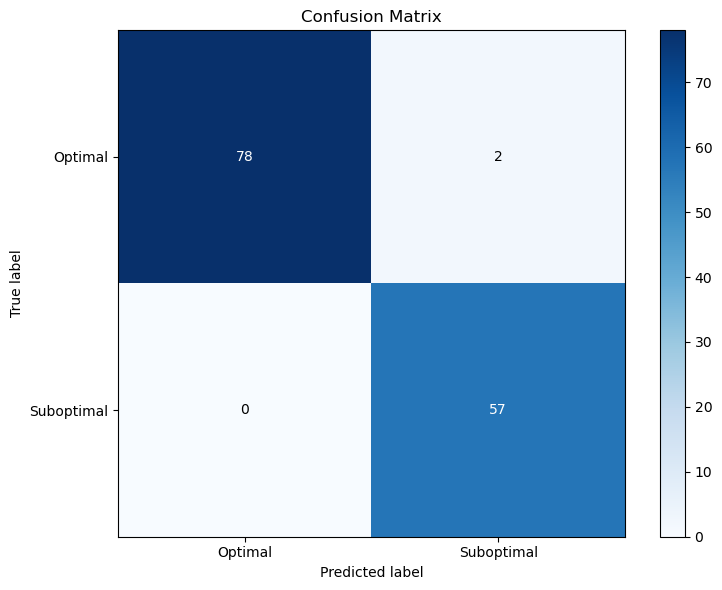

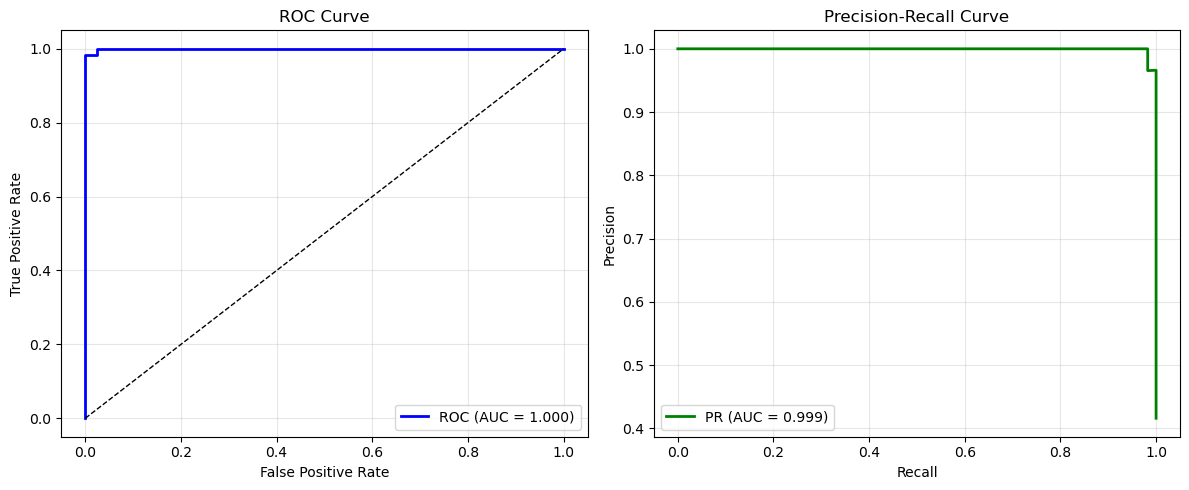

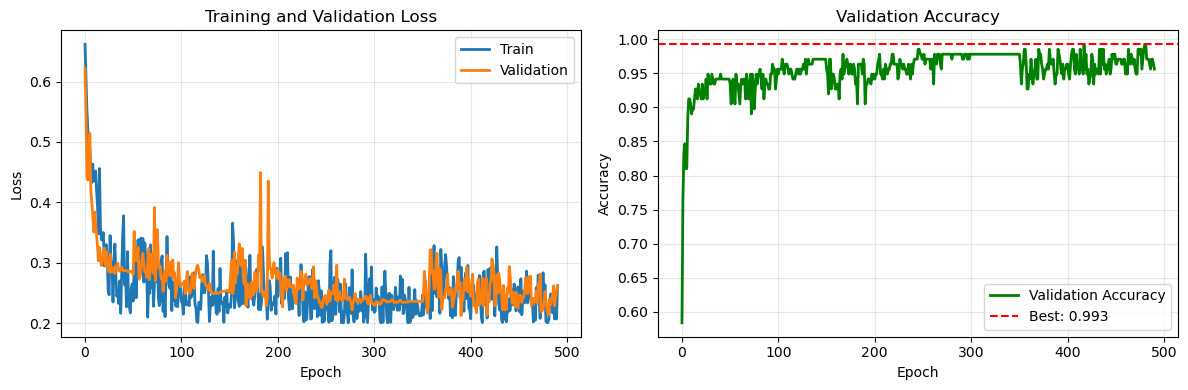

In [16]:
# ============================================================================
# EVALUATION ON VALIDATION SET
# ============================================================================

print("\n" + "="*60)
print("VALIDATION SET EVALUATION")
print("="*60)

val_metrics = evaluate_classifier(classifier, val_loader_labeled, ch_mean, ch_std, device)

print(f"\nValidation Accuracy: {val_metrics['accuracy']:.3f}")
print(f"ROC-AUC: {val_metrics['roc_auc']:.3f}")
print(f"PR-AUC: {val_metrics['pr_auc']:.3f}")

print("\nClassification Report:")
for cls_name in ['Optimal', 'Suboptimal']:
    cls_metrics = val_metrics['classification_report'][cls_name]
    print(f"  {cls_name}: precision={cls_metrics['precision']:.3f}, "
          f"recall={cls_metrics['recall']:.3f}, f1={cls_metrics['f1-score']:.3f}")

# Plot confusion matrix
fig_cm = plot_confusion_matrix(val_metrics['confusion_matrix'])
plt.show()

# Plot ROC and PR curves
fig_curves = plot_roc_pr_curves(val_metrics)
plt.show()

# Plot training curves
fig_train = plot_training_curves(history)
plt.show()


CHANNEL SENSITIVITY ANALYSIS

Channel Ranking by Sensitivity:
  1. Ch30: 0.1033
  2. Ch31: 0.0913
  3. Ch29: 0.0910
  4. Ch32: 0.0691
  5. Ch25: 0.0653
  6. Ch26: 0.0524
  7. Ch28: 0.0498
  8. Ch27: 0.0493


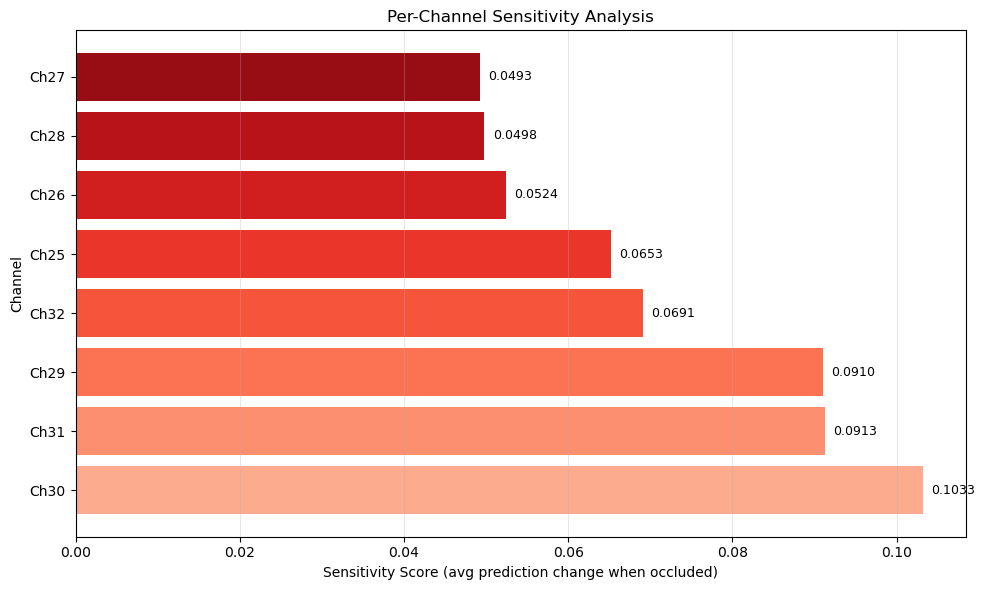

In [17]:
# ============================================================================
# CHANNEL SENSITIVITY ANALYSIS
# ============================================================================

print("\n" + "="*60)
print("CHANNEL SENSITIVITY ANALYSIS")
print("="*60)

sensitivity_results = channel_sensitivity_analysis(
    classifier, val_loader_labeled, ch_mean, ch_std, device, n_samples=200
)

print("\nChannel Ranking by Sensitivity:")
for rank, (ch_name, score) in enumerate(sensitivity_results['ranked_channels'], 1):
    print(f"  {rank}. {ch_name}: {score:.4f}")

# Plot channel sensitivity
fig_sens = plot_channel_sensitivity(sensitivity_results)
plt.show()


GRAD-CAM VISUALIZATION DEMO

Sample prediction: Suboptimal (prob=0.936)


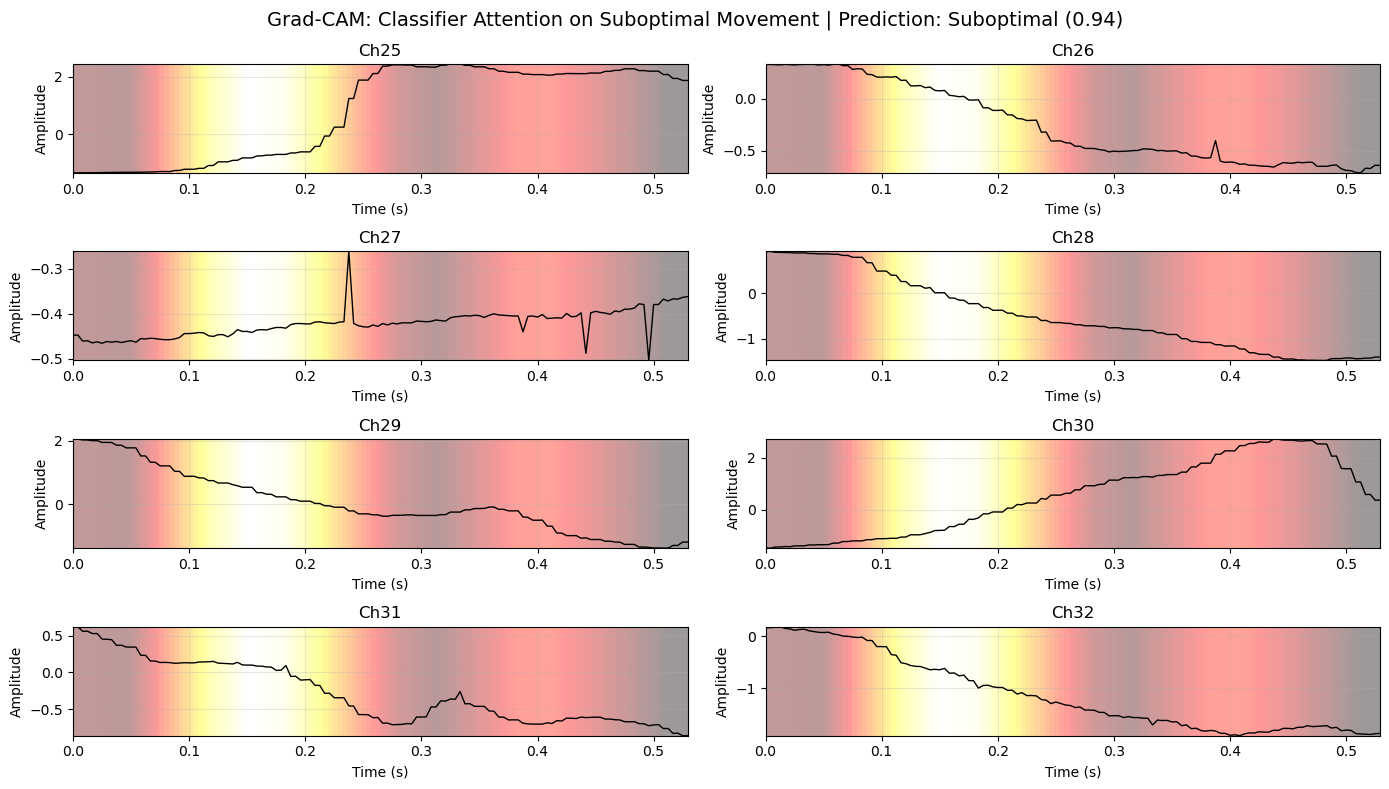

In [18]:
# ============================================================================
# GRAD-CAM VISUALIZATION DEMO
# ============================================================================

print("\n" + "="*60)
print("GRAD-CAM VISUALIZATION DEMO")
print("="*60)

# Create inference pipeline
inference = MovementQualityInference(classifier, ch_mean, ch_std, device)

# Find a suboptimal sample and visualize
found_suboptimal = False
for x, label in val_loader_labeled:
    for i in range(x.size(0)):
        if label[i] == 1:  # Suboptimal sample
            sample = x[i]
            result = inference.predict(sample)
            print(f"\nSample prediction: {result['prediction']} "
                  f"(prob={result['probability']:.3f})")
            
            fig_cam = plot_gradcam_heatmap(
                sample.numpy(), result['gradcam'], result['probability'],
                title="Grad-CAM: Classifier Attention on Suboptimal Movement"
            )
            plt.show()
            found_suboptimal = True
            break
    if found_suboptimal:
        break

if not found_suboptimal:
    print("No suboptimal samples found in validation set.")

In [19]:
# ============================================================================
# SAVE MODEL AND SUMMARY
# ============================================================================

print("\n" + "="*60)
print("SAVING MODEL")
print("="*60)

model_dir = save_classifier(classifier, cfg, ch_mean, ch_std, history)

# Summary
print("\n" + "="*60)
print("MOVEMENT QUALITY CLASSIFICATION - SUMMARY")
print("="*60)
print(f"\nModel: TCN Encoder + Classification Head")
print(f"  - Latent dim: {cfg.model.latent_dim}")
print(f"  - Parameters: {sum(p.numel() for p in classifier.parameters()):,}")
print(f"\nPerformance:")
print(f"  - Best val accuracy: {max(history['val_acc']):.3f}")
print(f"  - ROC-AUC: {val_metrics['roc_auc']:.3f}")
print(f"  - PR-AUC: {val_metrics['pr_auc']:.3f}")
print(f"\nMost Important Channels:")
for i, (ch, score) in enumerate(sensitivity_results['ranked_channels'][:3], 1):
    print(f"  {i}. {ch}: {score:.4f}")
print(f"\nModel saved to: {model_dir}")
print("="*60)


SAVING MODEL
Model saved to: models\classifier_20260213_154603

MOVEMENT QUALITY CLASSIFICATION - SUMMARY

Model: TCN Encoder + Classification Head
  - Latent dim: 64
  - Parameters: 529,121

Performance:
  - Best val accuracy: 0.993
  - ROC-AUC: 1.000
  - PR-AUC: 0.999

Most Important Channels:
  1. Ch30: 0.1033
  2. Ch31: 0.0913
  3. Ch29: 0.0910

Model saved to: models\classifier_20260213_154603
